# Melanoma Detection Assisngment

### Name: Srikrishna S Kashyap
### Executive PG Programme in Machine Learning & AI



Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
###Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## The path pointing to my Google Drive. Please change the path if you want to run at your end
basepath = "/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDetection/data/"
data_dir_train = pathlib.Path(basepath + "Train")
data_dir_test = pathlib.Path(basepath + "Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Creating train dataset here
## Used seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  batch_size = batch_size,
  image_size=(img_height, img_width),
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Creating validation dataset here
## Used seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  batch_size = batch_size,
  image_size=(img_height, img_width),
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
   )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
## We will also create the test data set using tf.keras.preprocessing.image_dataset_from_directory
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


### Visualize the data
#### Visualising one instance of all the nine classes present in the dataset

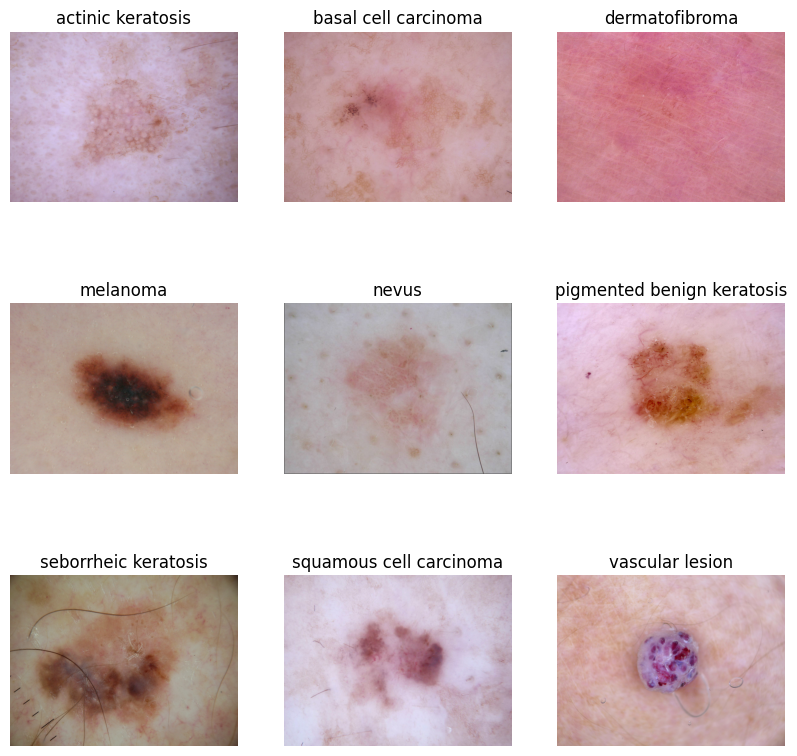

In [ ]:
from glob import glob

plt.figure(figsize=(10,10))
num_classes = len (class_names)
class_name_dict = {}

for lesion_type in range(num_classes):
    class_path = glob(os.path.join(data_dir_train, class_names[lesion_type], '*'))
    lesion_imgs = list(class_path)
    img=PIL.Image.open(str(lesion_imgs[0]))
    class_name_dict[ class_names[lesion_type] ] = len(lesion_imgs)
    ax = plt.subplot(3,3, lesion_type+1)
    plt.imshow(img)
    plt.title(class_names[lesion_type])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Code for the initial model

model = Sequential()

input_shape = (img_height, img_width, 3)

tf.keras.layers.InputLayer(input_shape=input_shape)

#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))

#Convulation Layer - 1
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Convulation Layer - 2
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Convulation Layer - 3
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model.add(layers.Flatten())

#Dense Layers
model.add(layers.Dense(128, activation='relu'))

#Dense Layer with softmax
model.add(layers.Dense(len(class_names),activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:

#Compiling the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])



In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       3

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 42s 64ms/step - loss: 1.8308 - accuracy: 0.3084 - val_loss: 1.4965 - val_accuracy: 0.4217
Epoch 2/20
169/169 [==============================] - 5s 30ms/step - loss: 1.4125 - accuracy: 0.4666 - val_loss: 1.2904 - val_accuracy: 0.4996
Epoch 3/20
169/169 [==============================] - 5s 28ms/step - loss: 1.2486 - accuracy: 0.5343 - val_loss: 1.1969 - val_accuracy: 0.5523
Epoch 4/20
169/169 [==============================] - 5s 28ms/step - loss: 1.1199 - accuracy: 0.5974 - val_loss: 1.0746 - val_accuracy: 0.5984
Epoch 5/20
169/169 [==============================] - 5s 30ms/step - loss: 0.9549 - accuracy: 0.6510 - val_loss: 0.9863 - val_accuracy: 0.6585
Epoch 6/20
169/169 [==============================] - 5s 28ms/step - loss: 0.7598 - accuracy: 0.7289 - val_loss: 1.0459 - val_accuracy: 0.6318
Epoch 7/20
169/169 [==============================] - 5s 29ms/step - loss: 0.6302 - accuracy: 0.7771 - val_loss: 0.8839 - val_accuracy: 0.697

### Visualizing training results

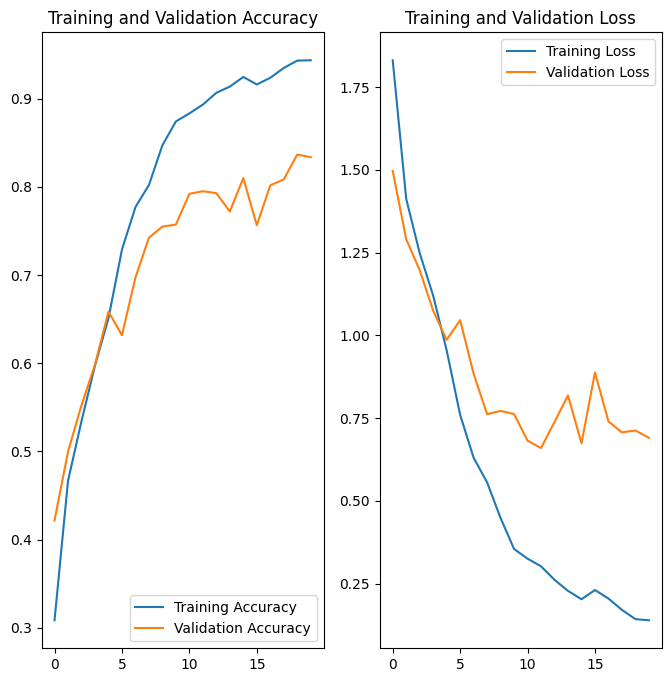

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings after the model fit

### Write your findings here

#### The model has badly **overfit.**
#### The training accuracy is sufficiently high (0.9436) and validation accuracy pretty low (0.8337)

#### Training loss has decreased to 0.1392 , however validation loss has decreased to 0.8337


In [ ]:
# We are trying out a data augumentation strategy.
# We will modify the images randomly ( Flip, Roation, Contrast/Brightness change etc )

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
  layers.RandomContrast(0.5),
  layers.RandomBrightness(0.3),
])



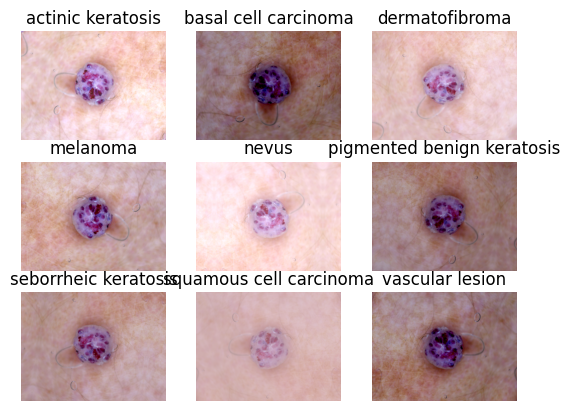

In [ ]:
# Visualising how augmentation strategy works for one instance of training image.
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(img)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")


### Creating the model, compiling and training the model


In [ ]:
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D

model = Sequential()

input_shape = (img_height, img_width, 3)

tf.keras.layers.InputLayer(input_shape=input_shape)

#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))

model.add(data_augmentation)

#Convulation Layer - 1
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.1))

#Convulation Layer - 2
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.1))

#Convulation Layer - 3
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.1))


#Flatten Layer
model.add(layers.Flatten())

#Dense Layers
model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dropout(0.5))


#Dense Layer with softmax
model.add(layers.Dense(len(class_names),activation='softmax'))



### Compiling the model

In [ ]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


### Training the model

In [ ]:
##  Training your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 11s 50ms/step - loss: 4.6246 - accuracy: 0.1343 - val_loss: 2.1913 - val_accuracy: 0.1359
Epoch 2/20
169/169 [==============================] - 8s 49ms/step - loss: 2.1828 - accuracy: 0.1426 - val_loss: 2.1866 - val_accuracy: 0.1403
Epoch 3/20
169/169 [==============================] - 8s 50ms/step - loss: 2.1799 - accuracy: 0.1352 - val_loss: 2.1865 - val_accuracy: 0.1403
Epoch 4/20
169/169 [==============================] - 8s 49ms/step - loss: 2.1777 - accuracy: 0.1402 - val_loss: 2.1873 - val_accuracy: 0.1403
Epoch 5/20
169/169 [==============================] - 8s 48ms/step - loss: 2.1857 - accuracy: 0.1450 - val_loss: 2.1873 - val_accuracy: 0.1403
Epoch 6/20
169/169 [==============================] - 8s 48ms/step - loss: 2.1763 - accuracy: 0.1447 - val_loss: 2.1880 - val_accuracy: 0.1403
Epoch 7/20
169/169 [==============================] - 8s 48ms/step - loss: 2.1766 - accuracy: 0.1372 - val_loss: 2.1884 - val_accuracy: 0.140

### Visualizing the results

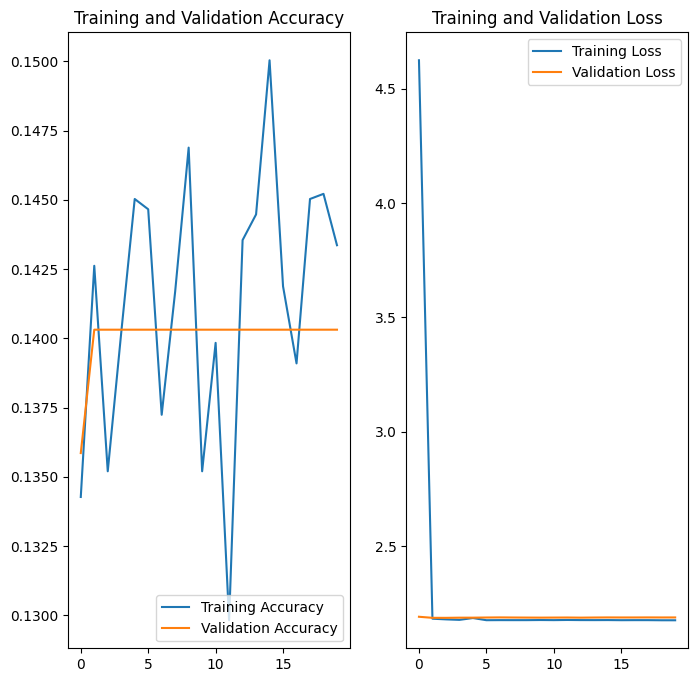

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit:

The training accuracy was 0.1434 and validation accuracy was 0.1403, both were pretty low.  

The augmentation strategy that I used ( just by randomly changing the images ) did not help and worsed the model performance

#### **Finding the distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
#Analyse the different classes
df = pd.DataFrame(class_name_dict.items(), columns=['Class', 'Count'])
print(df)

                        Class  Count
0           actinic keratosis    115
1        basal cell carcinoma    377
2              dermatofibroma     96
3                    melanoma    439
4                       nevus    358
5  pigmented benign keratosis    463
6        seborrheic keratosis     78
7     squamous cell carcinoma    182
8             vascular lesion    140


<Axes: xlabel='Class', ylabel='Count'>

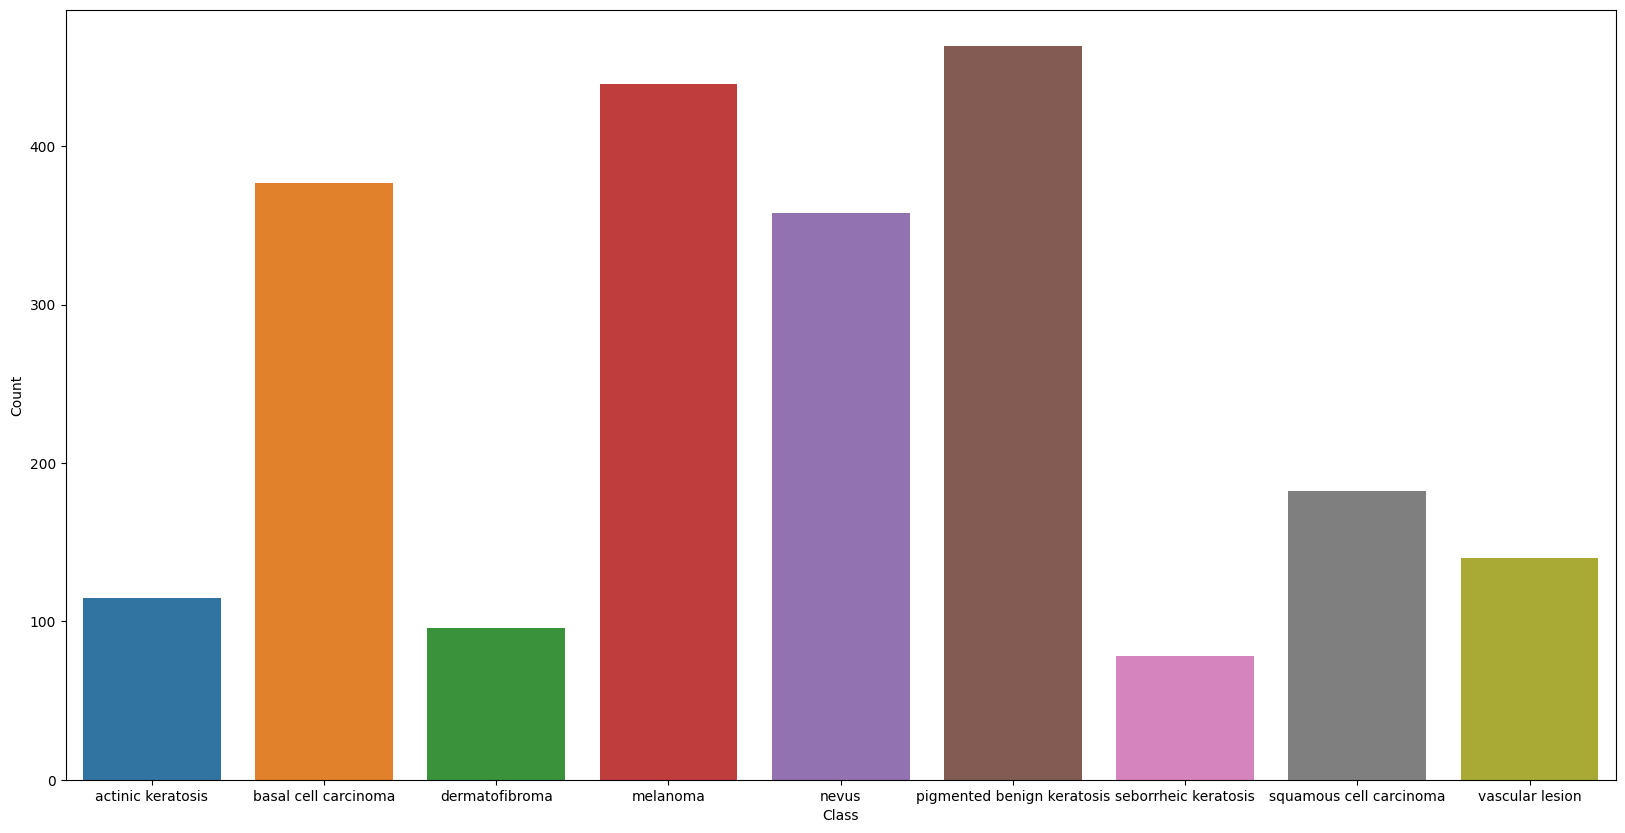

In [ ]:
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.barplot(x="Class", y="Count", data=df,
            label="Class")

#### Findings here:
#### The class **'seborrheic keratosis'** has least number of samples( 78 )
#### The classes **'pigmented benign keratosis(463)'** and **'melanoma(439)'** dominate data in terms proportionate number of samples

#### Rectifying the class imbalance
#### **Context:** Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
## Before augmentation, Capturing the details of the exiting data in a data frame before Augmentation
path_list = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,actinic keratosis
1,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,actinic keratosis
2,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,actinic keratosis
3,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,actinic keratosis
4,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,vascular lesion
2235,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,vascular lesion
2236,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,vascular lesion
2237,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,vascular lesion


In [ ]:
path_to_training_dataset= str(data_dir_train)

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/"+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN/MelanomaDetection/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C7F5B1F610>: 100%|██████████| 500/500 [00:19<00:00, 25.31 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN/MelanomaDetection/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C7F5937A00>: 100%|██████████| 500/500 [00:23<00:00, 21.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN/MelanomaDetection/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C7F5D257E0>: 100%|██████████| 500/500 [00:20<00:00, 24.34 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN/MelanomaDetection/data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3872x2592 at 0x78C7F59500A0>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN/MelanomaDetection/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x78C7F59AB790>: 100%|██████████| 500/500 [01:13<00:00,  6.77 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN/MelanomaDetection/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C7F5B62260>: 100%|██████████| 500/500 [00:18<00:00, 26.33 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN/MelanomaDetection/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78C7F5D25B70>: 100%|██████████| 500/500 [00:36<00:00, 13.62 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN/MelanomaDetection/data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78C7F599F910>: 100%|██████████| 500/500 [00:17<00:00, 28.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN/MelanomaDetection/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78C7F5B1FA90>: 100%|██████████| 500/500 [00:18<00:00, 27.11 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(new_df)
new_df

<ipython-input-29-1e0feeca45ae>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(new_df)


,Path,Label
0,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,actinic keratosis
1,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,actinic keratosis
2,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,actinic keratosis
3,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,actinic keratosis
4,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,actinic keratosis
...,...,...
8995,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,vascular lesion
8996,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,vascular lesion
8997,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,vascular lesion
8998,/content/gdrive/MyDrive/Upgrad/CNN/MelanomaDet...,vascular lesion


In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [ ]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="training",
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### Creating a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="validation",
  label_mode='categorical',  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### Creating model (making sure to include normalization)

In [ ]:
model = Sequential()

input_shape = (img_height, img_width, 3)

tf.keras.layers.InputLayer(input_shape=input_shape)

#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))

#Convulation Layer - 1
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Convulation Layer - 2
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))



#Convulation Layer - 3
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model.add(layers.Flatten())

#Dense Layers
model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dropout(0.3))

#Dense Layer with softmax
model.add(layers.Dense(len(class_names),activation='softmax'))

#### Compiling the model

In [ ]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


#### Training the model

In [ ]:
epochs = 30
## Using 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 67s 209ms/step - loss: 1.7653 - accuracy: 0.3291 - val_loss: 1.4379 - val_accuracy: 0.4490
Epoch 2/30
281/281 [==============================] - 53s 185ms/step - loss: 1.3167 - accuracy: 0.5100 - val_loss: 1.1370 - val_accuracy: 0.5941
Epoch 3/30
281/281 [==============================] - 55s 192ms/step - loss: 1.0813 - accuracy: 0.6042 - val_loss: 0.9169 - val_accuracy: 0.6782
Epoch 4/30
281/281 [==============================] - 52s 180ms/step - loss: 0.8408 - accuracy: 0.6967 - val_loss: 0.8218 - val_accuracy: 0.7276
Epoch 5/30
281/281 [==============================] - 53s 184ms/step - loss: 0.7024 - accuracy: 0.7483 - val_loss: 0.6345 - val_accuracy: 0.7873
Epoch 6/30
281/281 [==============================] - 60s 203ms/step - loss: 0.5815 - accuracy: 0.7884 - val_loss: 0.5701 - val_accuracy: 0.8158
Epoch 7/30
281/281 [==============================] - 54s 188ms/step - loss: 0.4449 - accuracy: 0.8394 - val_loss: 0.7593 - val_ac

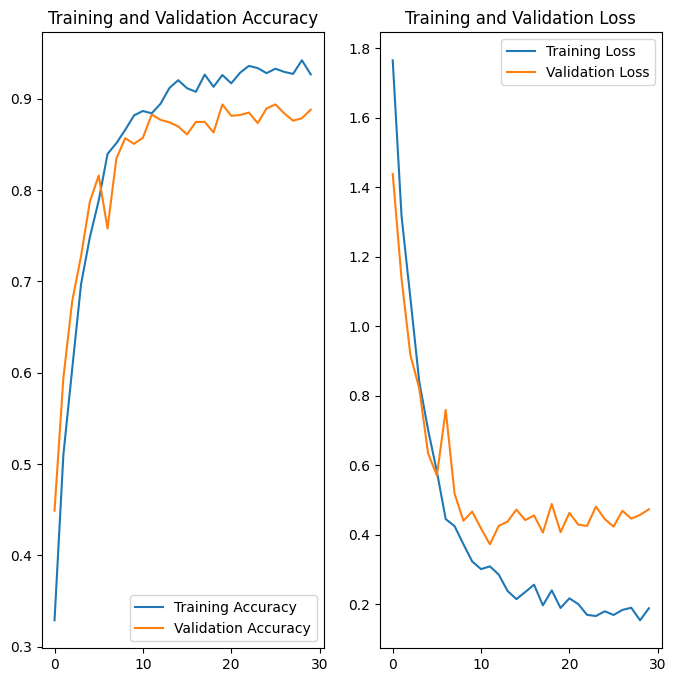

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analying results here.

#### By solving the class imbalance, we see that the problem of **'overfitting is sufficiently solved.'**

#### Training accuracy: **'0.9265'** and validation accuracy: **'0.8879'**

#### Also training loss = 0.1883, this has been reducing from the beggining.  The validation loss reduced till ~10 epoch and then remained stable ( final: 0.4732)

